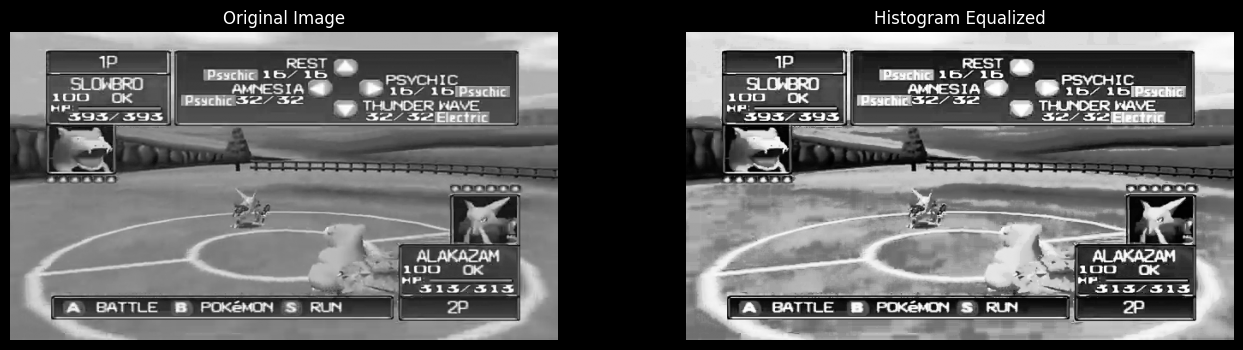

In [1]:
%matplotlib inline
import cv2
import matplotlib
# matplotlib.use('TkAgg')  # Use TkAgg backend for interactive plotting

import matplotlib.pyplot as plt

image_file = '/home/tmelanson/battle4/frame_000100.png'

# Read the image in grayscale
img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

# Perform histogram equalization
equalized_img = cv2.equalizeHist(img)

# Display original and equalized images
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Histogram Equalized')
plt.imshow(equalized_img, cmap='gray')
plt.axis('off')

plt.show()

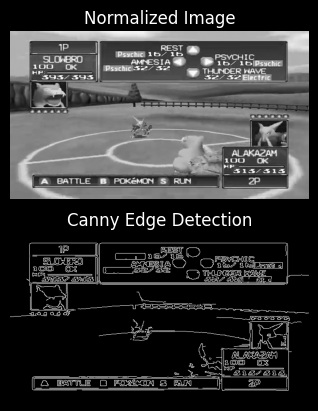

In [2]:
normalized_img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
plt.subplot(2,1, 1)
plt.title('Normalized Image')
plt.imshow(normalized_img, cmap='gray')
plt.axis('off')

# Perform Canny edge detection on the original grayscale image
edges = cv2.Canny(equalized_img, threshold1=200, threshold2=700)

# Display the edges
plt.subplot(2, 1, 2)
plt.title('Canny Edge Detection')
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

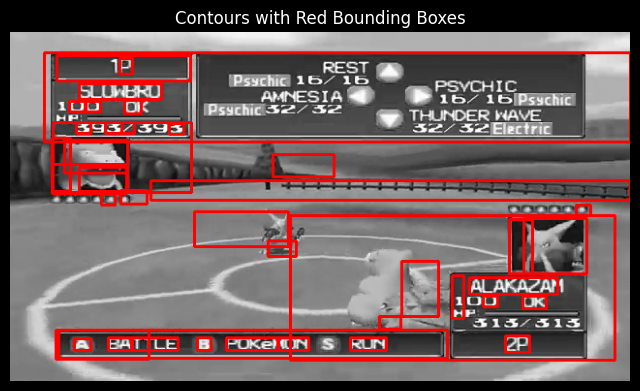

In [3]:
# Find contours in the edges image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert the original grayscale image to BGR color
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw red bounding boxes around each contour
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 10 and h > 10:
        cv2.rectangle(img_color, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red color in BGR

# Display the result
plt.figure(figsize=(8, 8))
plt.title('Contours with Red Bounding Boxes')
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

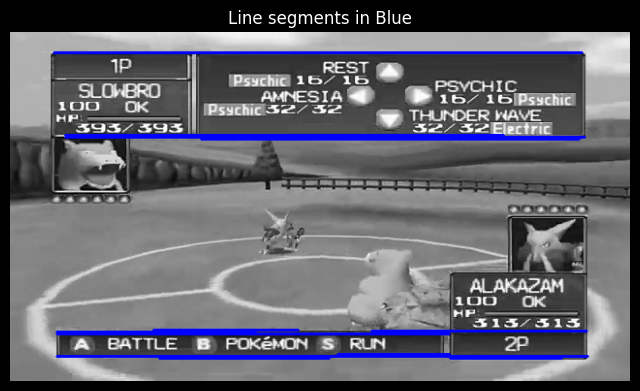

In [4]:
import numpy as np

# Perform Hough Line Transform to detect lines in the edges image
lines = cv2.HoughLinesP(edges, 1, np.pi / 4, 200, minLineLength=100, maxLineGap=10)
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to BGR for drawing lines

if lines is not None:
    # Draw the detected lines on the original image
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img_color, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue color in BGR

# Display the result
plt.figure(figsize=(8, 8))
plt.title('Line segments in Blue')
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Current HoughLinesP parameters analysis:
Theta resolution: np.pi / 4 = 0.7854 radians = 45.0 degrees
This means we only check angles at multiples of 45°: 0°, 45°, 90°, 135°, etc.
Vertical lines are at 90° (π/2 radians)

Trying with finer theta resolution (np.pi / 180 = 1 degree resolution):
Found 218 lines with finer resolution
Horizontal lines (green): 169
Vertical lines (blue): 19
Diagonal lines (red): 30


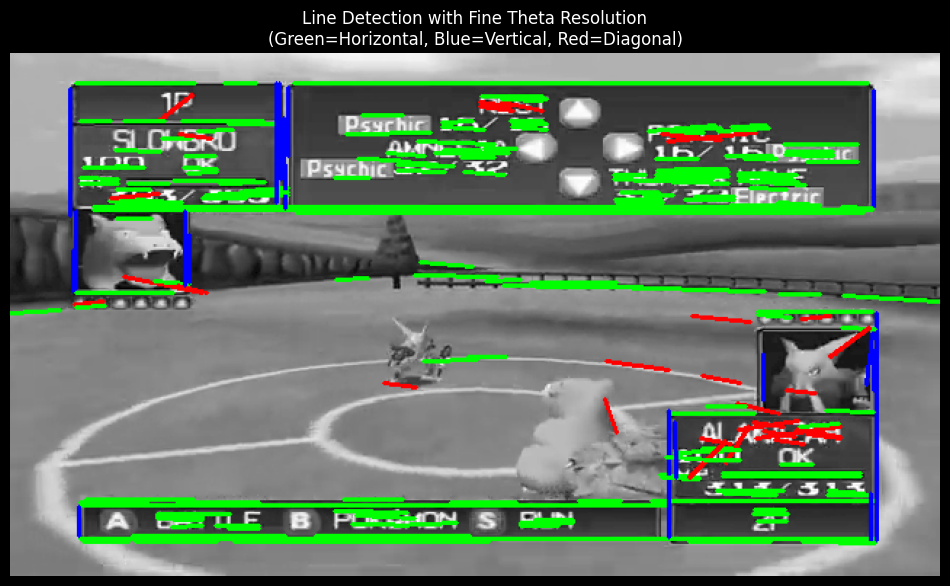

In [5]:
# Let's analyze why HoughLinesP doesn't find vertical lines
print("Current HoughLinesP parameters analysis:")
print(f"Theta resolution: np.pi / 4 = {np.pi / 4:.4f} radians = {np.degrees(np.pi / 4):.1f} degrees")
print("This means we only check angles at multiples of 45°: 0°, 45°, 90°, 135°, etc.")
print("Vertical lines are at 90° (π/2 radians)")
print()

# Let's try with better theta resolution for detecting all line orientations
print("Trying with finer theta resolution (np.pi / 180 = 1 degree resolution):")

# Use finer theta resolution to detect lines at all angles
lines_fine = cv2.HoughLinesP(edges, 1, np.pi / 180, 10, minLineLength=20, maxLineGap=5)
img_color_fine = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

if lines_fine is not None:
    print(f"Found {len(lines_fine)} lines with finer resolution")
    
    # Categorize lines by orientation
    horizontal_lines = []
    vertical_lines = []
    diagonal_lines = []
    
    for line in lines_fine:
        x1, y1, x2, y2 = line[0]
        
        # Calculate angle
        if x2 - x1 != 0:
            angle = np.arctan((y2 - y1) / (x2 - x1))
            angle_degrees = np.degrees(angle)
        else:
            angle_degrees = 90  # Vertical line
        
        # Categorize lines
        if abs(angle_degrees) < 5 or abs(angle_degrees) > 175:
            horizontal_lines.append(line)
            cv2.line(img_color_fine, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for horizontal
        elif abs(angle_degrees - 90) < 15 or abs(angle_degrees + 90) < 15:
            vertical_lines.append(line)
            cv2.line(img_color_fine, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for vertical
        else:
            diagonal_lines.append(line)
            cv2.line(img_color_fine, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red for diagonal
    
    print(f"Horizontal lines (green): {len(horizontal_lines)}")
    print(f"Vertical lines (blue): {len(vertical_lines)}")
    print(f"Diagonal lines (red): {len(diagonal_lines)}")
else:
    print("No lines found even with finer resolution")

# Display the result
plt.figure(figsize=(12, 8))
plt.title('Line Detection with Fine Theta Resolution\n(Green=Horizontal, Blue=Vertical, Red=Diagonal)')
plt.imshow(cv2.cvtColor(img_color_fine, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

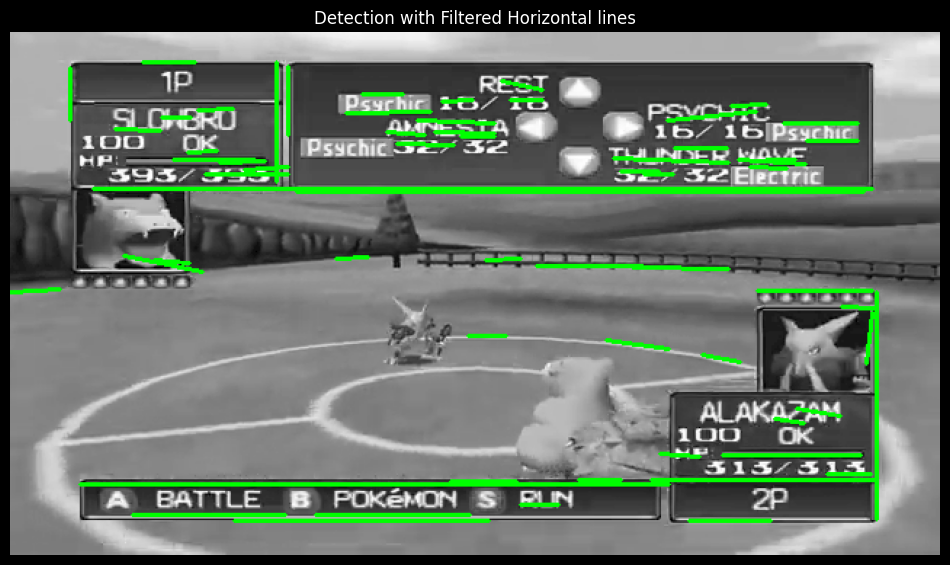

In [6]:
eps=5
# Get all the horizontal lines
horizontal_lines = [line for line in lines_fine if abs(line[0][1] == line[0][3]) < eps]
# For each horizontal line, take out similar lines
horizontal_lines_filtered = []
for line in horizontal_lines:
    existing_line = False
    for other_line in horizontal_lines_filtered:
        if abs(line[0][0] - other_line[0][0]) < eps:
            existing_line = True
            break
    if not existing_line:
        horizontal_lines_filtered.append(line)

img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for line in horizontal_lines_filtered:
    x1, y1, x2, y2 = line[0] 
    cv2.line(img_color, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for horizontal
# Display the result
plt.figure(figsize=(12, 16))
plt.title('Detection with Filtered Horizontal lines')
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

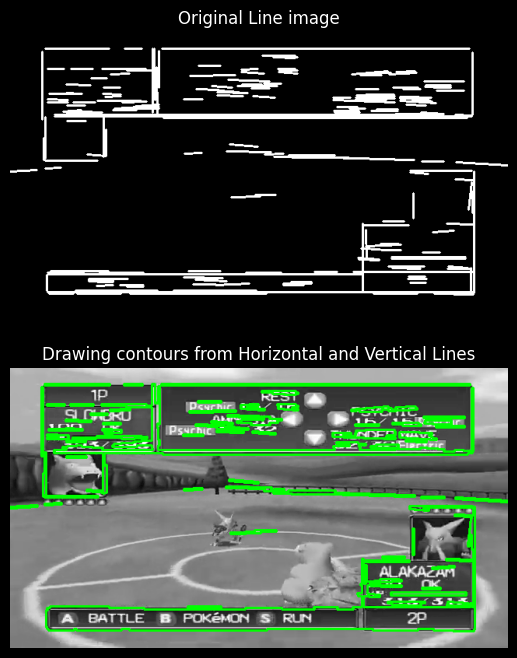

In [7]:
def get_line_img(img, lines_fine):
    line_img = np.zeros_like(img)
    for line in lines_fine:
            x1, y1, x2, y2 = line[0]
            
            # Calculate angle
            if x2 - x1 != 0:
                angle = np.arctan((y2 - y1) / (x2 - x1))
                angle_degrees = np.degrees(angle)
            else:
                angle_degrees = 90  # Vertical line

            if (abs(angle_degrees) > 5 and abs(angle_degrees) < 175) and (abs(angle_degrees - 90) > 15 and abs(angle_degrees + 90) > 15):
                continue # Not using diagonal lines
        
            cv2.line(line_img, (x1, y1), (x2, y2), (255, 255, 255), 2)  # White for all lines
    return line_img

line_img = get_line_img(img, lines_fine)
contours, hierarchy = cv2.findContours(line_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
original_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(original_img, contours, -1, (0, 255, 0), 2)  # Draw contours in green

# Display the result
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.title('Original Line image')
plt.imshow(line_img, cmap='gray')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.title('Drawing contours from Horizontal and Vertical Lines')
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
    

In [ ]:
import time
T1 = 200
T2 = 700
PIXEL_RES = 1
ANGLE_RES = np.pi / 180
THRESHOLD = 10
MIN_LINE_LENGTH = 20
MAX_LINE_GAP = 5

def predict(input_img):
    # Do histogram EQ, find edges
    equalized_img = cv2.equalizeHist(input_img)
    edges = cv2.Canny(equalized_img, threshold1=T1, threshold2=T2)
    # Find lines
    lines = cv2.HoughLinesP(edges, PIXEL_RES, ANGLE_RES, THRESHOLD, minLineLength=MIN_LINE_LENGTH, maxLineGap=MAX_LINE_GAP)
    # Get line image
    line_img = get_line_img(input_img, lines)
    # Find contours
    contours, hierarchy = cv2.findContours(line_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Copy image, draw on it
    original_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(original_img, contours, -1, (0, 255, 0), 2)  # Draw contours in green
    return original_img

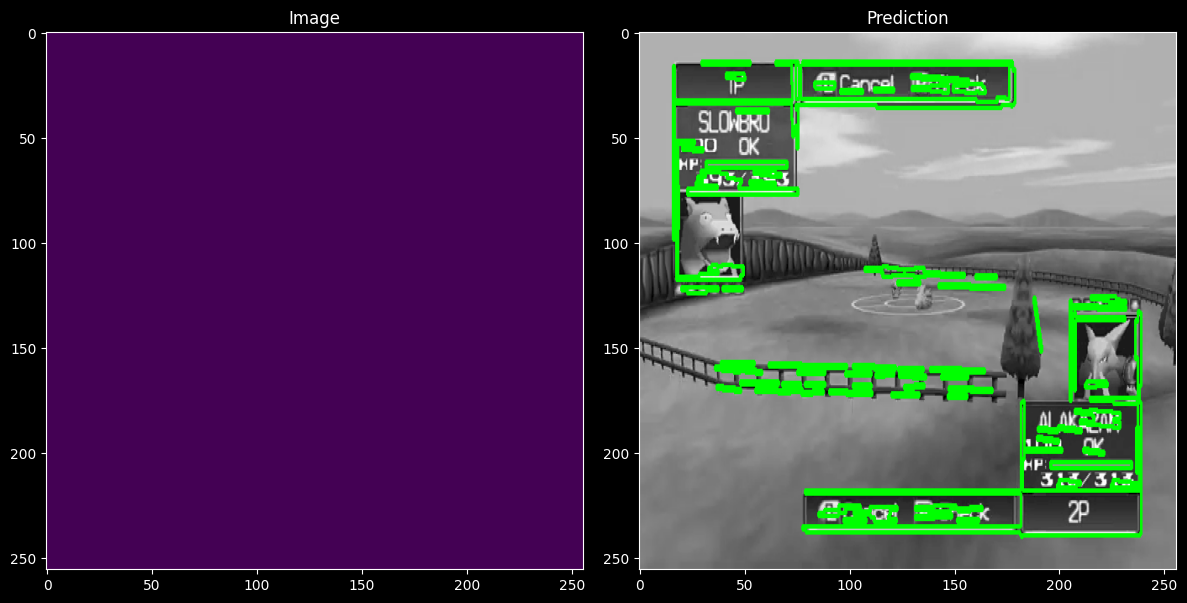

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cv2
import os
IMG_DIR= '/home/tmelanson/battle4'  # Adjust this path as needed

# matplotlib.use('TkAgg')  # Use TkAgg backend for interactive plotting
plt.ion()

from matplotlib.animation import FuncAnimation

fig, (ax_img, ax_pred) = plt.subplots(1, 2, figsize=(12, 6))
ax_img.set_title('Image')
ax_pred.set_title('Prediction')
img_img = ax_img.imshow(np.zeros((256, 256)), animated=True)  # Placeholder for image 
img_pred = ax_pred.imshow(np.zeros((256, 256, 3)), animated=True)  # Placeholder for prediction
img_keyword = 'frame' # Adjust this keyword based on your image naming convention


def init():
    # Initialize the model and load the best weights
    img_file =  os.path.join(IMG_DIR, f'{img_keyword}_000100.png')  # Adjust this path as needed
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    pred = predict(img)  # Get prediction from the model
    img_img.set_array(np.array(img))
    img_pred.set_array(pred)
    return [img_img, img_pred]


def update(i: int):
    # Initialize the model and load the best weights
    img_file =  os.path.join(IMG_DIR, f"{img_keyword}_{i:06d}.png")  # Adjust this path as needed
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    pred = predict(img)
    img_img.set_array(img)
    img_pred.set_array(pred)
    return [img_img, img_pred]

plt.tight_layout()
ani = FuncAnimation(fig, update, frames=range(100, 200), init_func=init, repeat=True, interval=100)
# Save the animation as a video file
ani.save('segmentation_animation_shallow.mp4', writer='ffmpeg', fps=30, dpi=300)
plt.show(block=True)